# Extended DMD with control for nonlinear systems
We demonstrate extended dynamic mode decomposition for control (EDMDc) applied to the classical forced Van der Pol oscillator
(this is example in Sec. 4 in Korda & Mezić, _"Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control"_, Automatica 2018), with dynamics given by:

$$\dot{x}_{1} = 2x_2 u,\\
\dot{x}_2 = -0.8x_1 + 2x_2 -10x_1^2x_2 + u$$

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import numpy.random as rnd
from numpy.random import default_rng
rng = default_rng(seed=42)

import warnings
warnings.filterwarnings('ignore')

import pykoopman as pk

Generating training data, where each trajectory starts at a random initial condition in the unit box $[-1,1]^2$ and is forced by a random control signal with values drawn from a uniform distribution over the interval $[-1,1]$.

In [65]:
n_states = 2 # Number of states
n_inputs = 1 # Number of control inputs
dT = 0.01    # Timestep

from pykoopman.common.examples import vdp_osc, rk4, square_wave

A training dataset is created consisting of 200 trajectories, each trajectory is integrated for 1000 timesteps and forced by a random actuation in the range $[-1,1]$.

In [66]:
n_traj = 200  # Number of trajectories
n_int = 1000  # Integration length
t = np.arange(0, n_int*dT, dT)

# Uniform forcing in [-1, 1]
u = rng.uniform(-1.0, 1.0, [n_int, n_traj])

# Uniform distribution of initial conditions
x = rng.uniform(-1.0, 1.0, [n_states, n_traj])

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))
U = np.zeros((n_inputs, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rk4(0, x, u[step, :], dT, vdp_osc)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    U[:, (step)*n_traj:(step+1)*n_traj] = u[step, :]
    x = y

t = np.arange(0, n_int*dT, dT)

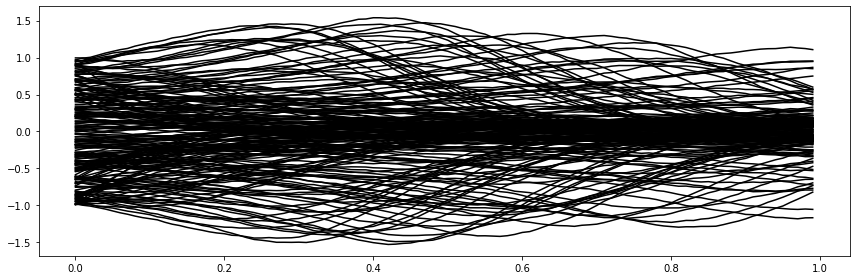

In [67]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs.plot(t[0:100], x[1, 0:100], 'k')

In [68]:
EDMDc = pk.regression.EDMDc()
RBF = pk.observables.RadialBasisFunction(rbf_type='gauss', n_centers=10, centers=None, kernel_width=1.0, polyharmonic_coeff=1.0)

model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(x=X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[ 0.02139159,  0.22066289,  1.1062073 , -1.12312511, -0.69351864,
         0.43206588, -0.78505148,  1.08378305,  1.03387673, -0.07667992],
       [ 0.79304391, -0.12000454, -0.08030883, -0.52432058,  0.19084936,
         1.23284135, -0.65372893, -1.52876734,  1.53849837,  1.00104472]])),
        regressor=EDMDc())

Compute inverse of training data using the estimated measurement matrix and calculate error:

In [69]:
print(np.linalg.norm((model.measurement_matrix() @ RBF.transform(X.T).T)-X)) # check inverse / measurement matrix

1.0572457373756169e-12


### Compare prediction accuracy of Koopman model on a test trajectory

Describe example

In [70]:
n_int = 300  # Integration length
t = np.arange(0, n_int*dT, dT)
u = np.array([-square_wave(step+1) for step in range(n_int)])
x = np.array([0.5, 0.5])
# x = np.array([[-0.1], [-0.5]])

# Integrate nonlinear system
Xtrue = np.zeros((n_states, n_int))
Xtrue[:, 0] = x
for step in range(1, n_int, 1):
    y = rk4(0, Xtrue[:, step-1].reshape(n_states,1), u[np.newaxis, step-1], dT, vdp_osc)
    Xtrue[:, step] = y.reshape(n_states,)

Predict using Koopman model

In [71]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop = model.simulate(x[np.newaxis,:], u[:, np.newaxis], n_steps=n_int)

Compare results

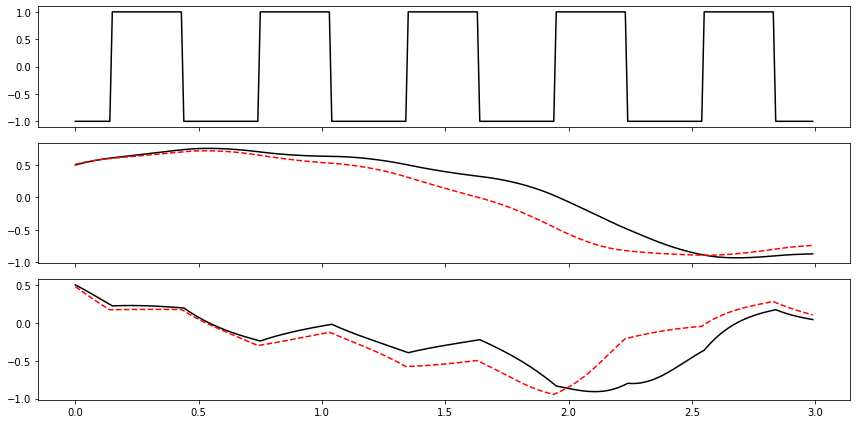

In [72]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(12, 6))
#sharey=True, gridspec_kw={'width_ratios': [2, 1]}
axs[0].plot(t, u, '-k')
# axs[0, 1].hist(u, bins=20, orientation="horizontal")
axs[1].plot(t, Xtrue[0, :], '-k')
axs[1].plot(t, Xkoop[:, 0], '--r')
axs[2].plot(t, Xtrue[1, :], '-k')
axs[2].plot(t, Xkoop[:, 1], '--r')